# Locality in Diffusion Models — Playground

This notebook lets you experiment with the analytical diffusion models

In [1]:
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf, open_dict
from torchvision.utils import make_grid

from local_diffusion.configuration import load_config
from local_diffusion.data import build_dataset
from local_diffusion.models import create_model
from local_diffusion.models.baseline_unet import BaselineUNet

/mnt/arteml/projects/locality-in-diffusion-models/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration

Edit the YAML below to change the dataset, model, or sampling parameters.


In [2]:
# Auto-detect device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load config from file with overrides for notebook use
#   Model options: pca_locality, wiener, optimal, nearest_dataset 
#   Dataset options: mnist, cifar10, celeba_hq, afhq, fashion_mnist
cfg = load_config("pca_locality/celeba_hq.yaml", overrides=[
    f"experiment.device={device}",
    "sampling.num_inference_steps=10",
    "sampling.num_samples=8",
    "dataset.num_workers=0",
])

print(f"Dataset: {cfg.dataset.name}, Model: {cfg.model.name}")

Using device: cuda
Dataset: celeba_hq, Model: pca_locality


## Load Dataset

In [3]:
dataset = build_dataset(cfg.dataset)
print(f"Dataset: {dataset.name}, Resolution: {dataset.resolution}, Channels: {dataset.in_channels}")

Dataset: celeba_hq, Resolution: 64, Channels: 3


## Load the model

Create and train (load/compute Wiener filter), then sample.


In [4]:
model = create_model(
    cfg.model.name,
    dataset=dataset,
    device=cfg.experiment.device,
    num_steps=cfg.sampling.num_inference_steps,
    params=OmegaConf.to_container(cfg.model.params),
)
model.train(dataset) # "Train" is not eaxcalty training since we are working with analytical models

PCALocalityDenoiser()

In [5]:
# Sample from our model
torch.manual_seed(cfg.experiment.seed)
generator = torch.Generator(device=cfg.experiment.device).manual_seed(cfg.experiment.seed)

result = model.sample(
    num_samples=cfg.sampling.num_samples,
    batch_size=cfg.sampling.batch_size,
    generator=generator,
    return_intermediates=True,
)

Sampling: 100%|██████████| 10/10 [04:01<00:00, 24.18s/step]


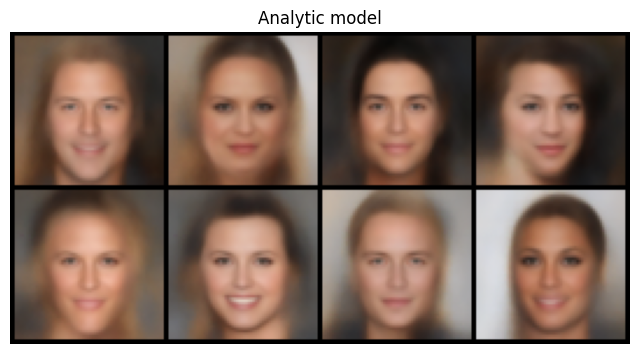

In [6]:

# Postprocess and visualize
images_ours = dataset.postprocess(result.images)
grid_ours = make_grid(images_ours, nrow=4, padding=2).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(grid_ours)
plt.title("Analytic model")
plt.axis("off")
plt.show()

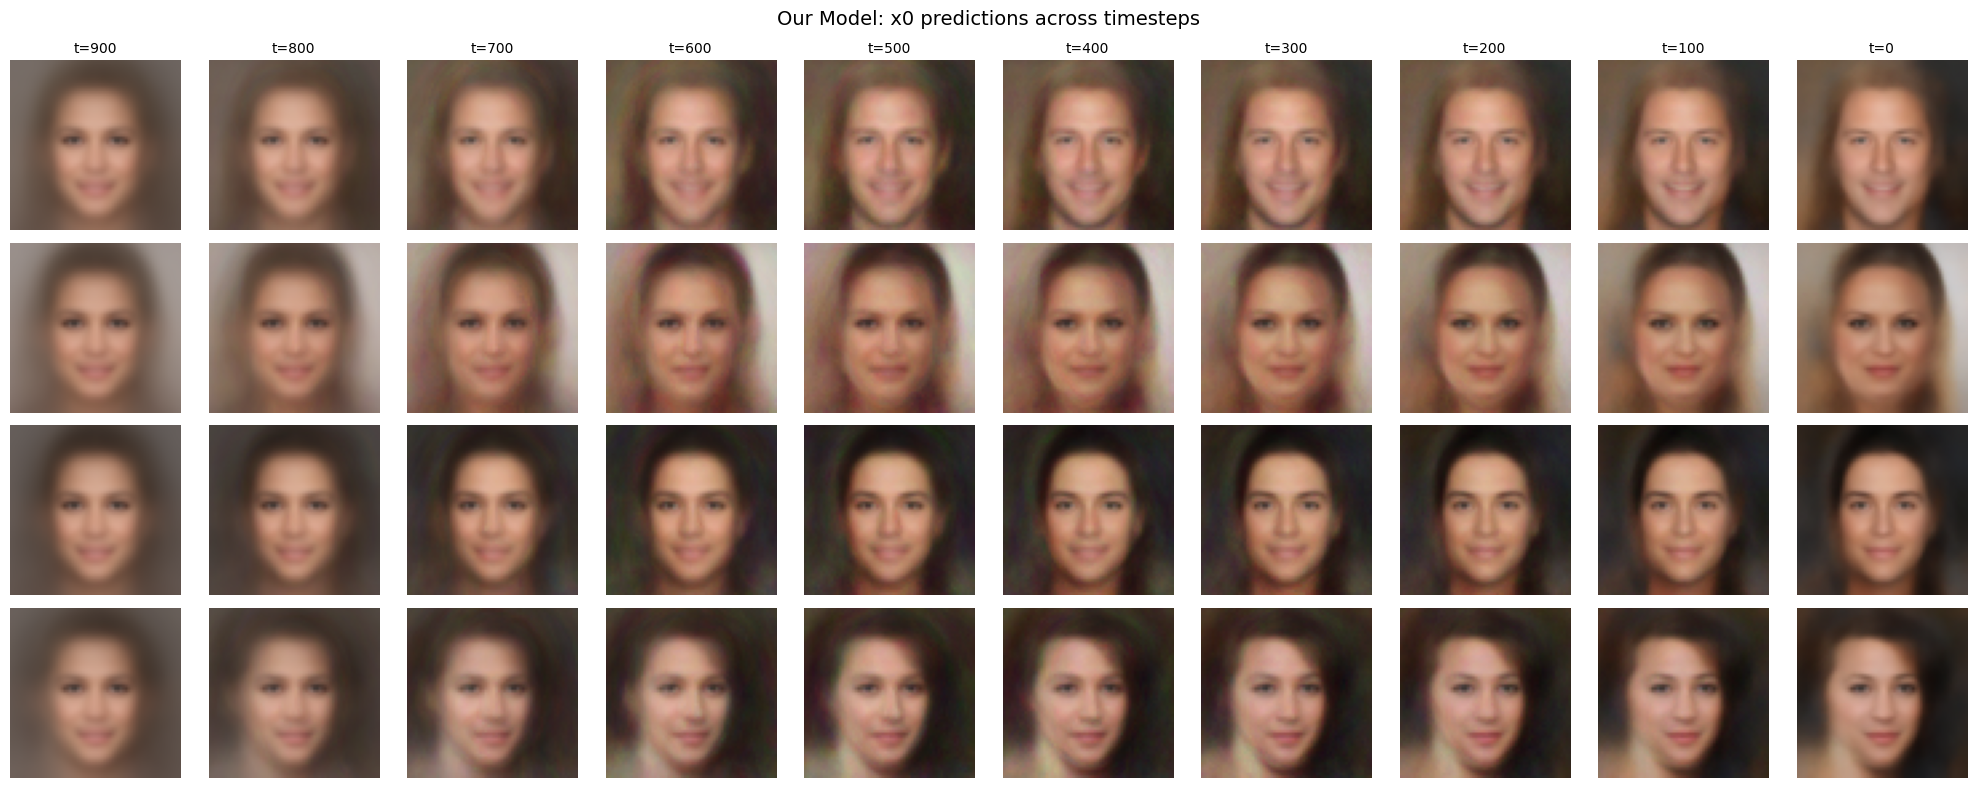

In [7]:
# Visualize x0 trajectory for our model
n_steps = len(result.trajectory_x0)
n_samples = min(4, result.trajectory_x0[0].shape[0])

fig, axes = plt.subplots(n_samples, n_steps, figsize=(2*n_steps, 2*n_samples))
for i in range(n_samples):
    for j, x0 in enumerate(result.trajectory_x0):
        img = dataset.postprocess(x0[i:i+1]).squeeze().permute(1, 2, 0).cpu().numpy()
        if img.shape[-1] == 1:
            img = img.squeeze(-1)
        axes[i, j].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axes[i, j].axis("off")
        if i == 0:
            axes[i, j].set_title(f"t={result.timesteps[j]}", fontsize=10)

fig.suptitle("Our Model: x0 predictions across timesteps", fontsize=14)
plt.tight_layout()
plt.show()


## Baseline: Trained UNet

Load the pretrained UNet and sample with the same seed.


In [8]:
baseline = BaselineUNet(
    resolution=dataset.resolution,
    device=cfg.experiment.device,
    num_steps=cfg.sampling.num_inference_steps,
    model_path=cfg.metrics.baseline_path,
    dataset_name=dataset.name,
    in_channels=dataset.in_channels,
    out_channels=dataset.in_channels,
)


Sampling: 100%|██████████| 10/10 [00:00<00:00, 20.54step/s]


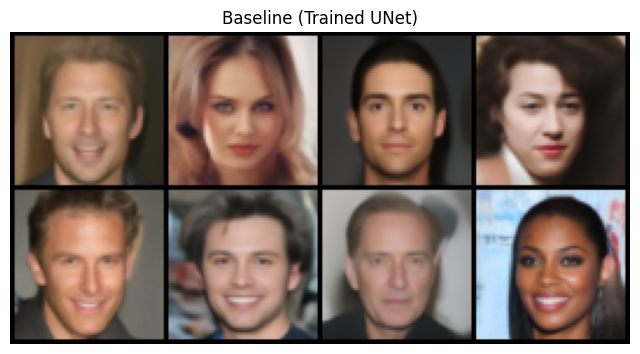

In [9]:
# Sample from baseline with same seed
torch.manual_seed(cfg.experiment.seed)
generator = torch.Generator(device=cfg.experiment.device).manual_seed(cfg.experiment.seed)

result_baseline = baseline.sample(
    num_samples=cfg.sampling.num_samples,
    batch_size=cfg.sampling.batch_size,
    generator=generator,
    return_intermediates=True,
)

images_baseline = dataset.postprocess(result_baseline.images)
grid_baseline = make_grid(images_baseline, nrow=4, padding=2).permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(grid_baseline)
plt.title("Baseline (Trained UNet)")
plt.axis("off")
plt.show()


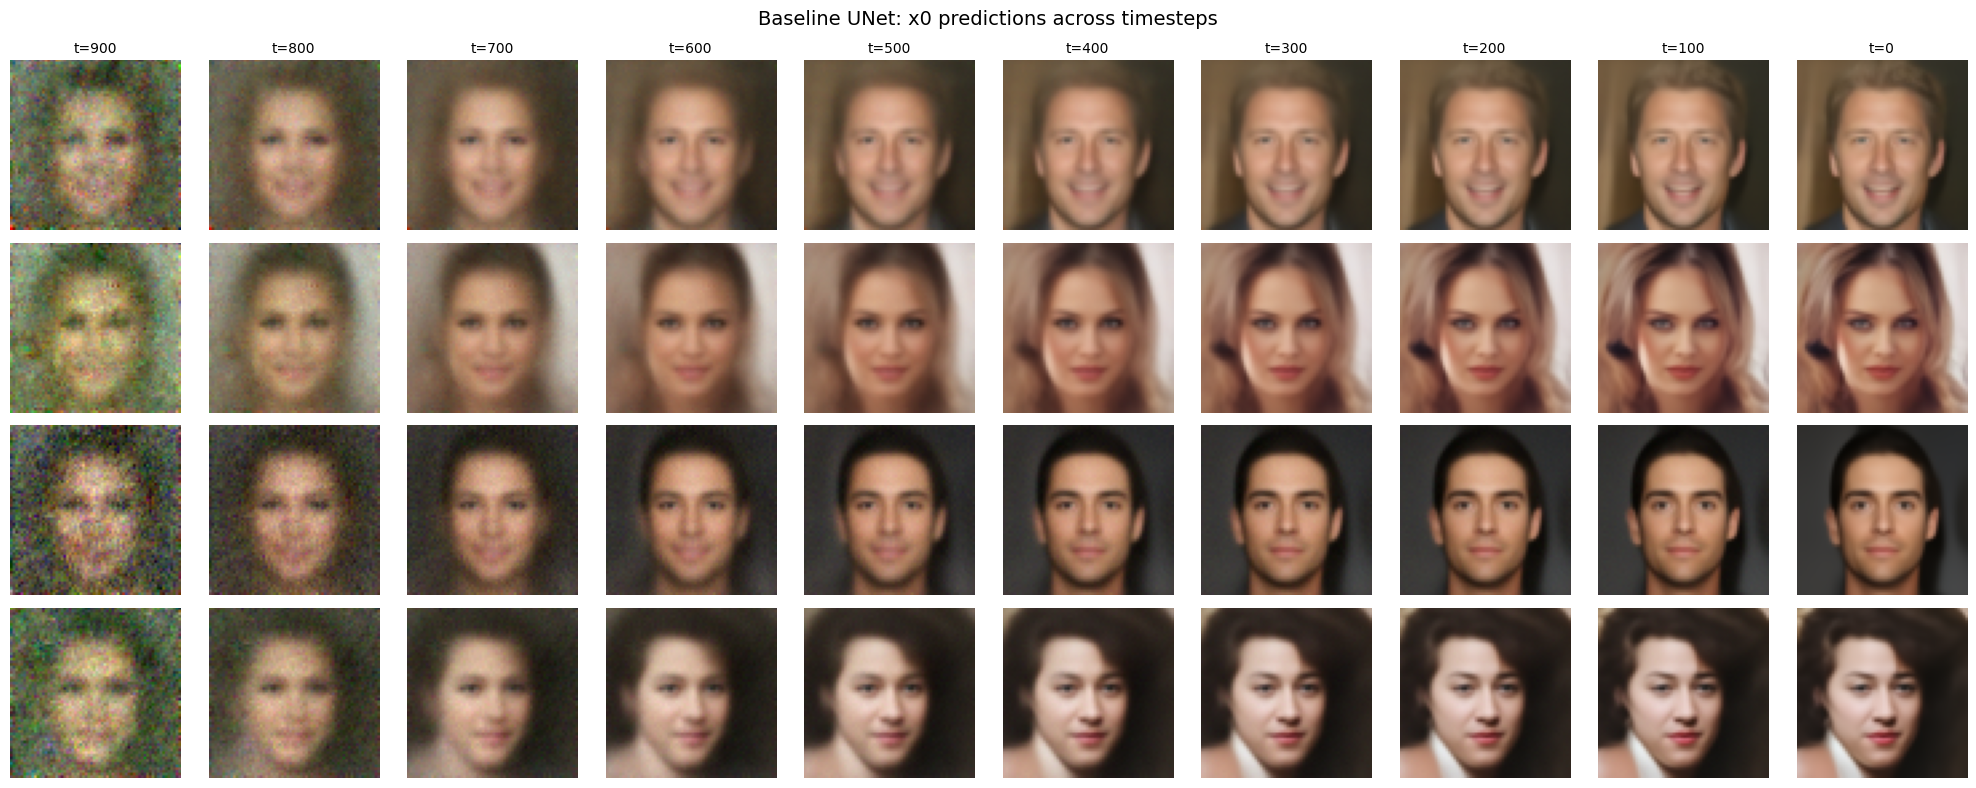

In [10]:
# Visualize x0 trajectory for baseline
n_steps = len(result_baseline.trajectory_x0)
n_samples = min(4, result_baseline.trajectory_x0[0].shape[0])

fig, axes = plt.subplots(n_samples, n_steps, figsize=(2*n_steps, 2*n_samples))
for i in range(n_samples):
    for j, x0 in enumerate(result_baseline.trajectory_x0):
        img = dataset.postprocess(x0[i:i+1]).squeeze().permute(1, 2, 0).cpu().numpy()
        if img.shape[-1] == 1:
            img = img.squeeze(-1)
        axes[i, j].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axes[i, j].axis("off")
        if i == 0:
            axes[i, j].set_title(f"t={result_baseline.timesteps[j]}", fontsize=10)

fig.suptitle("Baseline UNet: x0 predictions across timesteps", fontsize=14)
plt.tight_layout()
plt.show()


## Side-by-Side Comparison

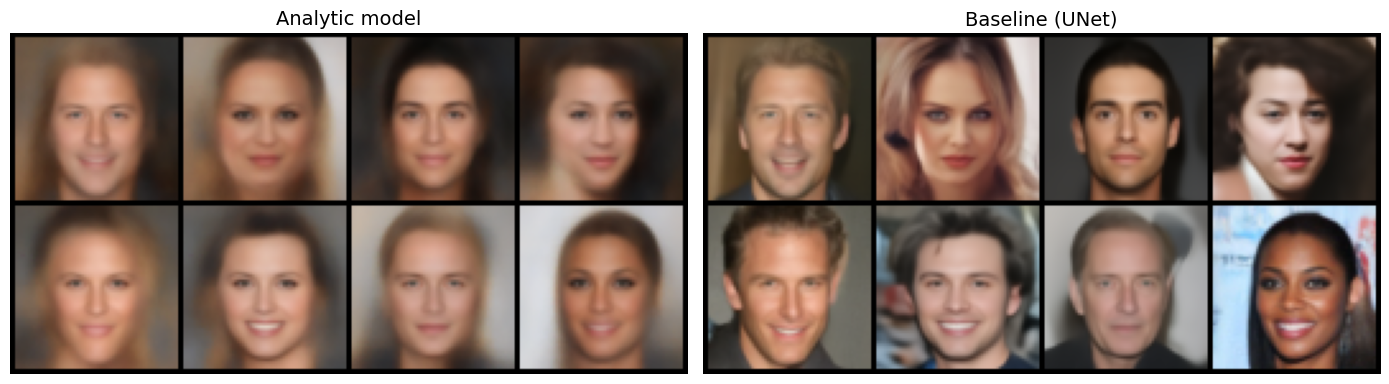

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].imshow(grid_ours)
axes[0].set_title("Analytic model", fontsize=14)
axes[0].axis("off")

axes[1].imshow(grid_baseline)
axes[1].set_title("Baseline (UNet)", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()
